In [1]:
# default_exp io

# Zarr

<br>

### Imports

In [1]:
#export
import pandas as pd
import xarray as xr
import numpy as np
import dask
import zarr
import gcsfs
import numcodecs

<br>

### User Inputs

In [3]:
james_zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr'
out_zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/full_extent_TM_zarr_int16'

<br>

### Loading Data

We'll start by defining a loading function and a replacement for the standard `gcsfs.utils` `is_retriable` function

In [4]:
#export
def is_retriable(exception):
    """Returns True if this exception is retriable."""
    errors = list(range(500, 505)) + [
        400, # Jack's addition.  Google Cloud occasionally throws Bad Requests for no apparent reason.
        408,# Request Timeout
        429, # Too Many Requests
    ]
    
    errors += [str(e) for e in errors]
    
    if isinstance(exception, gcsfs.utils.HttpError):
        return exception.code in errors

    return isinstance(exception, gcsfs.utils.RETRIABLE_EXCEPTIONS)

gcsfs.utils.is_retriable = is_retriable

def load_from_zarr_bucket(zarr_bucket):
    gcs = gcsfs.GCSFileSystem()
    store = gcsfs.GCSMap(root=zarr_bucket, gcs=gcs)
    ds = xr.open_zarr(store, consolidated=True)
    
    return ds

<br>

We'll now read it in

In [5]:
%%time

james_zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr'

james_xarray = load_from_zarr_bucket(james_zarr_bucket)

james_xarray

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Wall time: 10.8 s


,Array,Chunk
Bytes,3.02 TB,18.52 MB
Shape,"(163137, 704, 548, 12)","(1, 704, 548, 12)"
Count,163138 Tasks,163137 Chunks
Type,float32,numpy.ndarray


<br>

And plot a sample to check everything is working

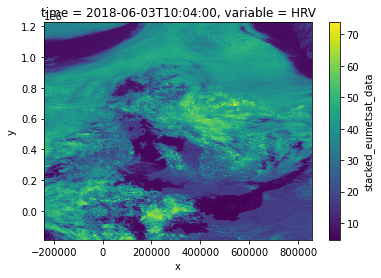

In [6]:
da_sample = james_xarray['stacked_eumetsat_data'].isel(time=720, variable=0)

da_sample.plot()

<br>

### Compression & Saving

We need to normalise the data before we can efficiently store it in 16 bits

In [7]:
#export
def add_constant_coord_to_da(da, coord_name, coord_val):
    """
    Adds a new coordinate with a 
    constant value to the DataArray
    
    Parameters
    ----------
    da : xr.DataArray
        DataArrray which will have the new coords added to it
    coord_name : str
        Name for the new coordinate dimensions
    coord_val
        Value that will be assigned to the new coordinates
        
    Returns
    -------
    da : xr.DataArray
        DataArrray with the new coords added to it
    
    """
    
    da = da.assign_coords({coord_name:coord_val}).expand_dims(coord_name)
    
    return da

class Compressor:
    def __init__(self, 
                 bits_per_pixel=10, 
                 mins=np.array([-1.2278595, -2.5118103, -64.83977, 63.404694, 2.844452, 199.10002, -17.254883, -26.29155, -1.1009827, -2.4184198, 199.57048, 198.95093]), 
                 maxs=np.array([103.90016, 69.60857, 339.15588, 340.26526, 317.86752, 313.2767, 315.99194, 274.82297, 93.786545, 101.34922, 249.91806, 286.96323]),
                 variable_order=['HRV', 'IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'VIS006', 'VIS008', 'WV_062', 'WV_073']
                ):
        
        locals_ = locals()
        attrs_to_add = ['bits_per_pixel', 'mins', 'maxs', 'variable_order']
        
        for attr in attrs_to_add:
            setattr(self, attr, locals_[attr])
            
        return
    
    def fit(self, da, dims=['time', 'y', 'x']):
        self.mins = da.min(dims).compute()
        self.maxs = da.max(dims).compute()
        self.variable_order = da.coords['variable'].values
        
        print(f'The mins are: {self.mins}')
        print(f'The maxs are: {self.maxs}')
        print(f'The variable order is: {self.variable_order}')
        
        return

    def compress(self, da):
        for attr in ['mins', 'maxs']:
            assert getattr(self, attr) is not None, f'{attr} must be set in initialisation or through `fit`'
            
        if 'time' not in da.dims:
            time = pd.to_datetime(da.attrs['end_time'])
            da = add_constant_coord_to_da(da, 'time', time)
    
        da = (da
              .reindex({'variable': self.variable_order})
              .transpose('time', 'y', 'x', 'variable')
             )
            
        upper_bound = (2 ** self.bits_per_pixel) - 1
        new_max = self.maxs - self.mins

        da -= self.mins
        da /= new_max
        da *= upper_bound

        da = (da
              .fillna(-1)
              .round()
              .astype(np.int16)
             )

        return da

In [8]:
### Should add in a test to check that no values exceed the min/max

<br>

Testing this out we can see it cuts the size of the dataset in half

In [9]:
%%time

compressor = Compressor()

compressor.compress(james_xarray['stacked_eumetsat_data'])

Wall time: 429 ms


,Array,Chunk
Bytes,1.51 TB,9.26 MB
Shape,"(163137, 704, 548, 12)","(1, 704, 548, 12)"
Count,1468236 Tasks,163137 Chunks
Type,int16,numpy.ndarray


<br>

We'll now create a helper function for saving the data-array to a zarr database

In [13]:
# export
def save_da_to_zarr(da, zarr_bucket, dim_order=['time', 'x', 'y', 'variable']):
    da = da.transpose(*dim_order)
    _, y_size, x_size, _ = da.shape
    out_store = gcsfs.GCSMap(root=zarr_bucket, gcs=gcsfs.GCSFileSystem())
    
    chunks = (36, y_size, x_size, 1)
    
    ds = xr.Dataset({'stacked_eumetsat_data': da.chunk(chunks)})
    
    encoding = {
        'stacked_eumetsat_data': {
            'compressor': numcodecs.Blosc(cname='zstd', clevel=5),
            'chunks': chunks
        }
    }
    
    ds.to_zarr(out_store, mode='w', encoding=encoding)
    
    return

<br>

Now we can save it!

In [14]:
da = james_xarray['stacked_eumetsat_data'].sel(time='2019-12-01')

save_da_to_zarr(da, out_zarr_bucket)

KeyboardInterrupt: 

In [2]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_utils.ipynb.
Converted 01_eumetsat.ipynb.
Converted 02_reproj.ipynb.
Converted 03_zarr.ipynb.
Converted 04_gcp.ipynb.
Converted 05_usage.ipynb.
Converted 06_pipeline.ipynb.


In [ ]:
# Disk space is priority, then look at io speeds
# 
# Priority order
# * notebook examples
# * airflow
# * end-to-end pipeline with benchmarking
# * publish documentation
# * add more tests

<br>

Brief
* Tweak Zarr data types to minimise storage space (e.g. re-scale all channels to [0, 1023] and store as int16s, with missing values encoded as -1; and compressed using zstd level 5).  (To re-scale to [0, 1023], you'll need to know the min and max values!  I've computed the mins and maxes for as 12 channels from James Fulton's 'all_zarr' array.  The mins and maxes are listed here.  Not sure if these mins and maxes will be the same after you've re-projected the entire geographical scope though.  
* Each Zarr chunk could be something like 32 timesteps, 512 pixels wide, 512 pixels high, and 1 channel.  (We're not sure how many channels will be useful for PV nowcasting.  So, it's probably best to keep the channels in separate chunks.)
* Would be great to use all the CPU cores on the VM.  If the reprojection library doesn't do this itself, then maybe consider spinning up multiple processes, maybe using concurrent.futures.ProcessPoolExecutor.map(worker_func, [list of native files to re-projected]); or using dask.delayed.  Zarr supports parallel writes as long as the writes are to different chunks (see Zarr's docs on parallel processing).
* One challenge will be that, if each Zarr chunk is multiple timesteps, then the conversion script may have to load multiple timesteps in memory, or in temporary files on the VM, before concatenating multiple timesteps into one Zarr chunk.
* When the script is finished processing a Native file, maybe we should move the native file to a cheaper storage class (e.g. coldline storage or archive storage).

<br>

### WMS Notes

https://en.wikipedia.org/wiki/Tiled_web_map

Conventions:
* Tiles are 256x256 pixels
* At the outer most zoom level, 0, the entire world can be rendered in a single map tile.
* Each zoom level doubles in both dimensions, so a single tile is replaced by 4 tiles when zooming in. This means that about 22 zoom levels are sufficient for most practical purposes.
* The Web Mercator projection is used, with latitude limits of around 85 degrees.
* An X and Y numbering scheme
* PNG images for tiles
* Images are served through a Web server, with a URL like http://.../Z/X/Y.png, where Z is the zoom level, and X and Y identify the tile.
* Tile Map Service: (0 to 2zoom-1, 2zoom-1 to 0) for the range (-180, +85.0511) - (+180, -85.0511).